In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from svetlanna.units import ureg

# Diffraction on the thin slit

We will calculate the diffraction of the plane wave on the thin slit using rectangular aperture from `svetlanna.elements`

## Creating numerical mesh with using `SimulationParameters` class

In [2]:
D = 0.1 * ureg.mm   # width of the slit
d = 0.5 * ureg.mm   # height of the slit

wavelength = 660 * ureg.nm  # wavelength

lx = 4 * ureg.mm  # width of the screen
ly = 4 * ureg.mm  # height of the screen

# distance from the slit to the screen
z = 3 * ureg.cm

# number of nodes along x and y
Nx = 1600
Ny = 1600

# creating SimulationParameters exemplar
sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [3]:
# return 2d-tensors of x and y coordinates
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Creating a plane wave using `svetlanna.wavefront.plane_wave`

Let's create a plane wave that will fall on the aperture:

In [4]:
# create plane wave
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=sim_params,
    distance=0 * ureg.cm,
    wave_direction=[0, 0, 1]
)

## Creating a thin slit using `svetlanna.elements.RectangularAperture`

In [5]:
slit = elements.RectangularAperture(
    simulation_parameters=sim_params,
    height=d,
    width=D,
)

Let's see the shape of the aperture using `.get_transmission_function()` class method:

In [6]:
slit_transmission_function = slit.get_transmission_function()

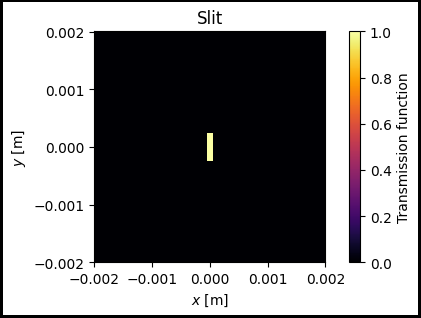

In [7]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, slit_transmission_function, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Slit')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Transmission function')

## Intensity profile on the screen after propagation through the slit

In this section we will solve the direct problem of diffraction on a slit using Angular Spectrum method from `FreeSpace` class

In [9]:
field_after_slit = slit.forward(
    incident_wavefront=incident_field
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=z,
    method="AS"
)

output_wavefront = free_space.forward(
    incident_wavefront=field_after_slit
)

output_intensity = output_wavefront.intensity

Visualize the intensity distribution:

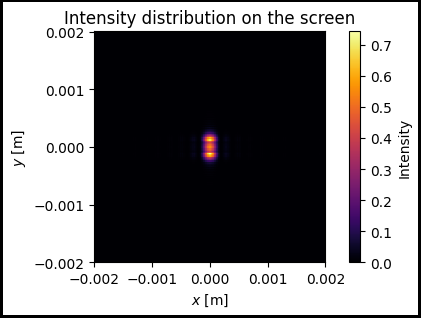

In [10]:
fig, ax = plt.subplots(figsize=(6, 3), edgecolor='black', linewidth=3,
                       frameon=True)
im1 = ax.pcolormesh(x_grid, y_grid, output_intensity, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity distribution on the screen')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
fig.colorbar(im1, label='Intensity')

# Comparing with diffraction grating equation

Using the diffraction grating equation $D \sin{\theta}=m\lambda$, where m is the order of diffraction, we can find the position of the intensity minima:

In [11]:
# array of min
m  = np.arange(1,8,1)
x_min = np.sqrt(m**2 * wavelength**2 * z**2 / (D**2 - m**2 * wavelength**2))

Text(0, 0.5, 'Amplitude')

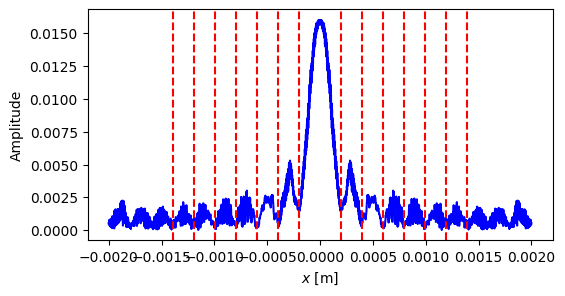

In [16]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x_grid[0], torch.sqrt(output_intensity)[250], color='blue')

[ax.axvline(x, ls='--', color='r') for x in x_min]
[ax.axvline(-x, ls='--', color='r') for x in x_min]

ax.set_xlabel('$x$ [m]')
ax.set_ylabel('Amplitude')
